# So you want to start a company...

The leaders of the world's top businesses have to start somewhere. Using the Crunchbase data, we take a look at where these business leaders received their educations. Is it true that you need to attend a world class institution to be successful, or is the business world much more varied in terms of educational backgrounds?

In [51]:
% matplotlib inline
# Overhead
import MySQLdb
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display
from modules import *

Since the crunchbase data is in the form of MySQL database dumps, we have already loaded this information into a MySQL database locally. See ___________ for instructions if you have not done this already. 

Next, we connect to that database and save a couple information tables locally as pandas DataFrames.

In [4]:
conn = dbConnect()
people = dbTableToDataFrame(conn,'cb_people')
degrees = dbTableToDataFrame(conn,'cb_degrees')
funding_rounds = dbTableToDataFrame(conn,'cb_funding_rounds')
objects = dbTableToDataFrame(conn,'cb_objects')
conn.close()

## The most successful businesses

If we consider a successful business to be one that has raised the most capital through a variety of funding rounds, we can sort our dataset accordingly.

We can get the total raised by a company by using the `funding_total_usd` column in the objects database. Note that we only want to use companies, so we only select those with an `entity_type` of "company". We will also reduce the size of our dataframe to include only a couple important metrics.

In [5]:
companies = objects[objects.entity_type=='Company'][['name','entity_id','funding_total_usd','closed_at']].copy()
# Only select companies who have raised some money
companies = companies.dropna(subset=['funding_total_usd'])
display(companies.sort_values('funding_total_usd',ascending=False).head(20))

comp_tot = len(companies)
print('There are {:,} companies in the dataset'.format(comp_tot))

,name,entity_id,funding_total_usd,closed_at
4575,Clearwire,13219,5700000000,None
160023,"Verizon Communications, Inc.",4843,3985050000,None
97784,sigmacare,242735,2600000000,None
161551,Facebook,5,2425700000,None
175825,Carestream,64365,2400000000,None
81001,Solyndra,22568,1765504319,None
170979,Fisker Automotive,5951,1451000000,None
151715,O3b Networks,39799,1270283000,None
101987,Terra-Gen Power,24693,1200000000,None
2971,Twitter,12,1160166511,None


There are 27,874 companies in the dataset


Now that we have all of the companies, let's define exactly what we mean by the most successful companies. First, to get a feel for the data visually, let's look at the top 100 companies and their fundraising totals.

/Users/mitch/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


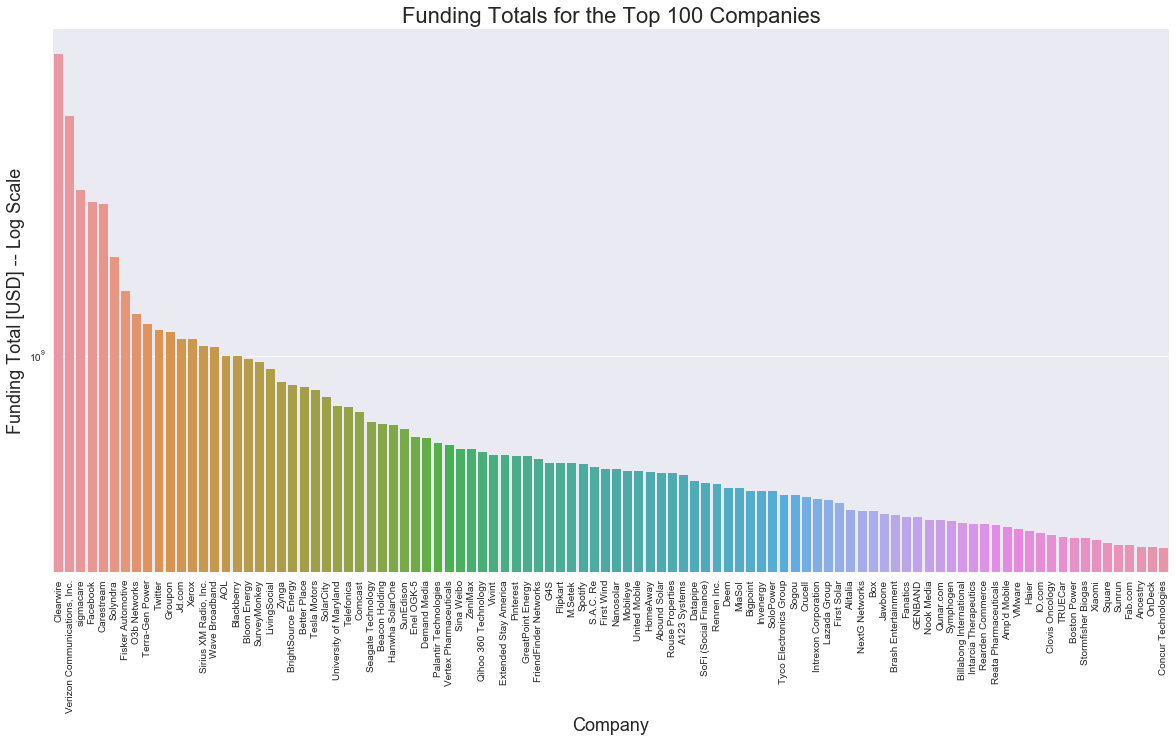

In [6]:
fig,ax = plt.subplots(figsize=(20,10))
n_top_companies = 100
plotset = companies.sort_values('funding_total_usd',ascending=False).head(n_top_companies)
ax = sns.barplot(x='name',y='funding_total_usd',data=plotset)
ax.set_title('Funding Totals for the Top {} Companies'.format(n_top_companies),fontsize=22)
ax.set_xticklabels(labels=plotset.name,rotation='vertical')
ax.set_xlabel('Company',fontsize=18)
ax.set_yscale('log')
ax.set_ylabel('Funding Total [USD] -- Log Scale',fontsize=18);

Note that the y-axis is on a logarithmic scale, and so the visible trend is dramatically underexaggerated.

It appears that only a handful of the companies fundraise greater than \$1 billion (\$$10^9$), though many more companies appear to fundraise in the millions. Let's find the exact percent of companies for each order of magnitude.

In [7]:
I,F = 3,10
for i in np.logspace(I,F,F-I+1):
    num_above = len(companies[companies['funding_total_usd']>i])
    frac = num_above/comp_tot
    print('{:,} companies ({}%) above ${:,}'.format(num_above,round(100*frac,1),int(i)))

27,854 companies (99.9%) above $1,000
27,608 companies (99.0%) above $10,000
24,960 companies (89.5%) above $100,000
18,112 companies (65.0%) above $1,000,000
7,309 companies (26.2%) above $10,000,000
630 companies (2.3%) above $100,000,000
15 companies (0.1%) above $1,000,000,000
0 companies (0.0%) above $10,000,000,000


We see from this that only slightly more than 25% of the companies fundraise more than $10 million. Let's define these 7309 companies as the most successful.

## The people behind the most successful businesses

Next, we can use the people database to pair individuals with the company they are affiliated with. Like for the funding rounds data, we don't need all of the information provided in the database of people either. Since we ultimately want to look at educational factors, let's limit the dataset to only a person's name (first and last), `object_id`, and affiliation, in a key that will let us link to the degrees dataset.

In [8]:
people_key = people[['affiliation_name','first_name','last_name','object_id']]
display(people_key.head(10))

ppl_tot = len(people_key)
print('There are {:,} people in the dataset'.format(ppl_tot))

,affiliation_name,first_name,last_name,object_id
0,Blue Nile,Ben,Elowitz,p:2
1,Wetpaint,Kevin,Flaherty,p:3
2,Zoho,Raju,Vegesna,p:4
3,Zoho,Ian,Wenig,p:5
4,i/o Ventures,Kevin,Rose,p:6
5,Digg,Jay,Adelson,p:7
6,Digg,Owen,Byrne,p:8
7,Digg,Ron,Gorodetzky,p:9
8,Facebook,Mark,Zuckerberg,p:10
9,Facebook,Dustin,Moskovitz,p:11


There are 226,709 people in the dataset


Now we merge the two datasets together to get each funded company and people in the crunchbase dataset who were involved.

In [9]:
company_people = pd.merge(companies,people_key,left_on='name',right_on='affiliation_name').drop(columns='affiliation_name')
display(company_people.head())

cp_tot = len(company_people)
print('There are {:,} people affiliated with funded companies in the dataset'.format(cp_tot))

,name,entity_id,funding_total_usd,closed_at,first_name,last_name,object_id
0,Wetpaint,1,39750000,None,Kevin,Flaherty,p:3
1,Wetpaint,1,39750000,None,Alex,Weinstein,p:104800
2,FriendFeed,1001,5000000,None,Paul,Buchheit,p:640
3,FriendFeed,1001,5000000,None,Sanjeev,Singh,p:2716
4,Fitbit,10015,68069200,None,James,Park,p:16930


There are 12,168 people affiliated with funded companies in the dataset


Interestingly, there are significantly fewer people associated with companies than there are people in the dataset.

We can now repeat the merging process with the dataset of educational information. First, let's limit the degrees dataset to include only degree type, institution, subject, and the id of the corresponding person (`object_id`). Then, we merge this into the database of companies and people.

In [10]:
edu = degrees[['object_id','institution','degree_type','subject']].dropna(subset=['institution'])
CPE = pd.merge(company_people,edu,on='object_id')
display(CPE.head(10))

,name,entity_id,funding_total_usd,closed_at,first_name,last_name,object_id,institution,degree_type,subject
0,Wetpaint,1,39750000,None,Kevin,Flaherty,p:3,Washington University in St Louis,BBA,None
1,Wetpaint,1,39750000,None,Kevin,Flaherty,p:3,Indiana University,MBA,None
2,FriendFeed,1001,5000000,None,Paul,Buchheit,p:640,Case Western Reserve University,MS,Computer Science
3,FriendFeed,1001,5000000,None,Sanjeev,Singh,p:2716,Stanford University,BS,Computer Science
4,Fitbit,10015,68069200,None,James,Park,p:16930,Harvard University,DNF,Computer Science
5,Fitbit,10015,68069200,None,Eric,Friedman,p:16931,George Washington University,BBA,Business Marketing
6,Fitbit,10015,68069200,None,Meena,Srinivasan,p:89236,"India, Certified Public Accountant in California",Chartered Accountant,None
7,Fitbit,10015,68069200,None,Meena,Srinivasan,p:89236,East Carolina University,MBA,None
8,Fitbit,10015,68069200,None,Mark,Silverio,p:121130,Boston College,BS,Marketing
9,Fitbit,10015,68069200,None,Eric,Friedman,p:216979,Yale University,MS,Computer Science


Finally, we filter the dataset of company, people, and education to only those in the most successful businesses (those who fundraised more than $10 million).

In [11]:
successful_CPE = CPE[CPE['funding_total_usd']>10_000]
display(successful_CPE.head())

n_entries = len(CPE)
n_unique_ppl = CPE['object_id'].nunique()
print('There are {:,} entries in the dataset, and {:,} unique people in the dataset.'.format(n_entries,n_unique_ppl))
print('On average, successful businesses involve people with an average of {} degrees.'.format(round(n_entries/n_unique_ppl,1)))

,name,entity_id,funding_total_usd,closed_at,first_name,last_name,object_id,institution,degree_type,subject
0,Wetpaint,1,39750000,None,Kevin,Flaherty,p:3,Washington University in St Louis,BBA,None
1,Wetpaint,1,39750000,None,Kevin,Flaherty,p:3,Indiana University,MBA,None
2,FriendFeed,1001,5000000,None,Paul,Buchheit,p:640,Case Western Reserve University,MS,Computer Science
3,FriendFeed,1001,5000000,None,Sanjeev,Singh,p:2716,Stanford University,BS,Computer Science
4,Fitbit,10015,68069200,None,James,Park,p:16930,Harvard University,DNF,Computer Science


There are 10,823 entries in the dataset, and 6,768 unique people in the dataset.
On average, successful businesses involve people with an average of 1.6 degrees.


We see that out of the 12,168 people in the full dataset, more than half are associated with well performing businesses. We also see that it is quite common for those at successful businesses to have multiple degrees.

# (Not so) humble beginnings

Next we take a look at the institutions who have produced the people affiliated with the successful businesses. If we were to take a closer look at the table above, you would see that many of the institutions are duplicated, but often with slight variations for each school.

In [12]:
#for inst in np.sort(CPE['institution'].unique()):
#    print(inst)

We will try to eliminate some of these duplicates, while at the same time reducing the names in such a way that we can properly aggregate a school when it is named alternatively. We will do this by defining a function which processes a list of school names, removes punctuation and superfluous word (often we are not interested in specific business schools or law schools, and we want inputs like "University of California–Berkeley" and "University of California, Berkeley" to be treated the same. Note: the function defined here relies on a more complicated "SchoolTools" class which is contained in the `modules` module.

In [46]:
def identify_institutions(institutions):
    '''
    Identify institutions using a common name.
    
    Each person in the database has a university which was input by a user. 
    These inputs are not uniform, and so names are inconsistent for some schools.
    (e.g. Berkeley could be UC Berkeley, Cal, or The University of California)
    
    Parameters
    ----------
    institutions : Series
        A series giving a list of institutions to be identified.
        
    Returns
    -------
    inst : Series
        A series where insitutions have been commonly identified.
    
    '''
    ST = SchoolTools()
    # Make all words lowercase
    inst=institutions.str.lower()
    #Remove stopwords
    inst = ST.remove_stopwords(inst)
    # Remove punctuation
    inst = ST.remove_punctuation(inst)
    # Replace common stems with just the stem, delete others, and replace keywords and nicknames with a common title.
    inst = ST.identify_schools(inst)
    return inst.str.title() 

In [47]:
cpe = CPE.copy()
cpe.institution=identify_institutions(cpe.institution)

This dataset is still quite large by itself. To reduce it's size, we will only focus on those schools which have contributed 15 or more people to successful businesses.

In [48]:
people_contributed_min = 15
inst_counts = pd.DataFrame(cpe.institution.value_counts())
inst_counts = inst_counts.rename(columns={'institution':'total'})
inst_mult = inst_counts[inst_counts.total>=people_contributed_min]
cpe_count = pd.merge(cpe,inst_mult,left_on='institution',right_index=True).sort_values('total',ascending=False)
cpe_count.head()

,name,entity_id,funding_total_usd,closed_at,first_name,last_name,object_id,institution,degree_type,subject,total
10708,Zillow,959,96627980,None,Christopher,Roberts,p:2556,Stanford,BS,Mechanical Engineering,618
7501,Facebook,5,2425700000,None,Sandra Liu,Huang,p:15296,Stanford,BS,Computer Science,618
6930,Apture,4421,4600000,None,Can,Sar,p:18982,Stanford,BS,Computer Science,618
6931,Apture,4421,4600000,None,Can,Sar,p:18982,Stanford,MS,Computer Science,618
7040,MUBI,4524,8245630,None,Efe,Cakarel,p:9537,Stanford,MBA,None,618


To make more sense of this dataset, we will plot according to universities which have contributed the most people to successful businesses.

/Users/mitch/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


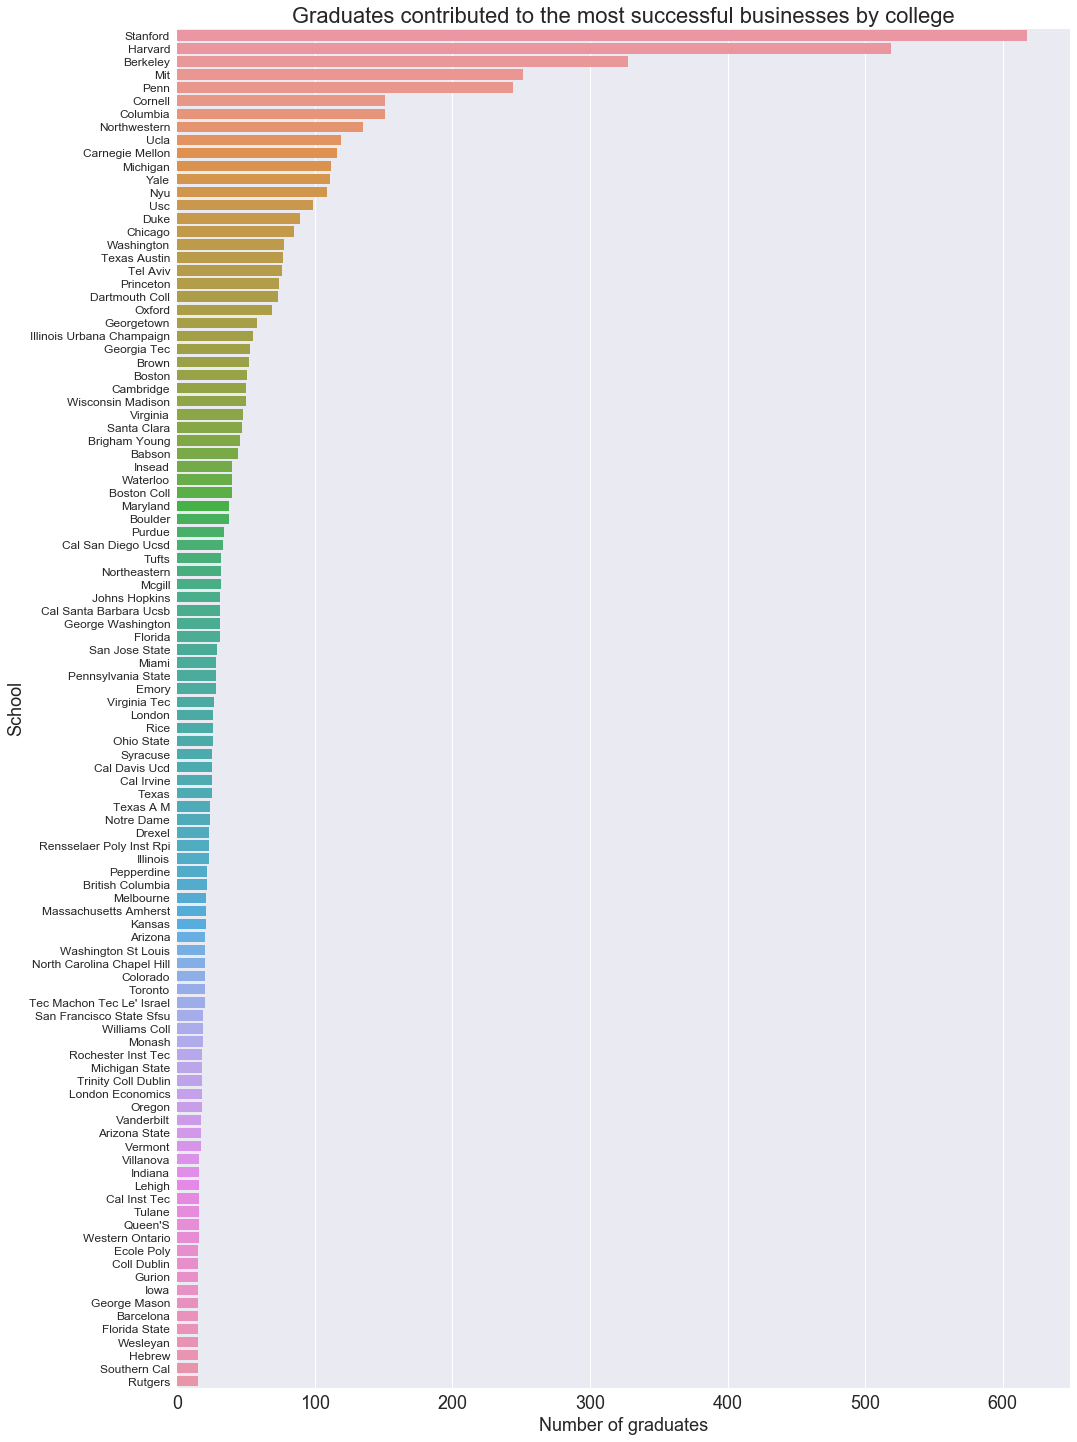

In [49]:
fig,edu_ax = plt.subplots(figsize=(16,25))
edu_ax = sns.barplot(x='total',y='institution',data=cpe_count)
edu_ax.set_title('Graduates contributed to the most successful businesses by college',fontsize=22)
edu_ax.tick_params(labelsize=18)
edu_ax.set_yticklabels(labels=cpe_count.institution.unique(),fontsize=12)
edu_ax.set_xlabel('Number of graduates',fontsize=18);
edu_ax.set_ylabel('School',fontsize=18);

We can see that there are several universities contributing far more graduates to the top businesses than the rest. Just the top three schools (Stanford, Harvard, and UC Berkeley) produce more than 13% of executives and founders of these companies.

In [50]:
cum_frac = 0
for top_school in ['Stanford','Harvard','Berkeley']:
    frac = inst_counts.total.loc[top_school]/inst_counts.total.sum()
    cum_frac += frac
    print('{} has {}% of the total graduates in top businesses.'.format(top_school,round(100*frac,1)))
print('Together, these three schools produced {}% of the total graduates in top businesses.'.format(round(100*cum_frac,1)))

Stanford has 5.7% of the total graduates in top businesses.
Harvard has 4.8% of the total graduates in top businesses.
Berkeley has 3.0% of the total graduates in top businesses.
Together, these three schools produced 13.5% of the total graduates in top businesses.
